<a href="https://colab.research.google.com/github/lsoica/blog/blob/main/assets/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer perceptron

## Terms

- Linear layer: applies a linear transformation to the input, i.e., $y = Wx + b$ where $W \in \mathbb{R}^{n \times m}$ is the weight matrix and $b \in \mathbb{R}^m$ is the bias vector. On the columns of $W$, each column represents a neuron. The number of features in the input has to match the number of weights of each neuron. The bias vector is added to the output of each neuron. In the result matrix on the rows we have the transformed input data by each neuron (so if the input data has 3 features, after the transformation it can end up having any number of features, equal to the number of neurons). Each cell is a dot product between the input vector and the weight of each neuron, so it captures the similarity between the input and the neuron. Each neuron is responsible for 1 output feature.
- Activation function: If the data is not linearily separable (through a line in 2D or a plane in 3D and so on) then it cannot be modeled by the MLP through just linear layers, that are just linear transformations. Just chaining multiple linear transformations is equivalent to a single linear transformation. We need to add nonlinearities between the layers, that are responsible for capturing the nonlinearity of the data. The most common activation functions are: ReLU (Rectified Linear Unit): $f(x) = max(0, x)$
- Data fitting: we have a series of points and we want to fit a line that passes through them

## Universal approximation theorem

Given a family of neural networks, for each function $f$ from a certain function space, there exists a sequence of neural networks $\phi _{1}$, $\phi _{2}$, ... from the family, such that $\phi _{n}\to f$ according to some criterion. That is, the family of neural networks is dense in the function space.

It states that feedforward networks with non-polynomial (non linear) activation functions are dense in the space of continuous functions between two Euclidean spaces, with respect to the compact convergence topology. It does not guarantee any method, such as backpropagation, might actually find such a sequence. Any method for searching the space of neural networks, including backpropagation, might find a converging sequence, or not (i.e. the backpropagation might get stuck in a local optimum).

It is the theoretical foundation for MLPs.

## Alternaltives

### KAN - Kolmogorov-Arnold Networks

- Bezier curves: Bézier curves are parametric curves (with the parameter t varying from 0 to 1) that are defined by a set of control points. These points’ positions in relation to one another define the shape of the curve.
- B-Splines: B-splines are piecewise polynomials, which means that they are made up of smaller pieces (called knots) that are joined together by continuity conditions. The most common type of B-spline is a cubic B-spline. A cubic B-spline is a curve that has 4 control points and 3 knots.

Based on the Kolmogorov-Arnold representation theorem, instead of learning weights like in the case of MLPs, they learn a function that maps a vector to another vector. 
The functions are learned in terms of control points. The control points are then used as the basis for the B-spline representation.

[Kolmogorov-Arnold Networks Paper](https://arxiv.org/abs/2404.19756)

## Let's train a multi-layer perceptron model to classify MNIST digits using PyTorch

### Install missing packages

In [ ]:
!pip install torchvision


### Import libraries

In [4]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Using PyTorch version: 2.4.1


### Load data

Dataset represents the actual data items, such as images or pieces of text, and their labels.
DataLoader is used for processing the dataset in batches in an efficient manner.

In [ ]:
batch_size = 32

data_dir = './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

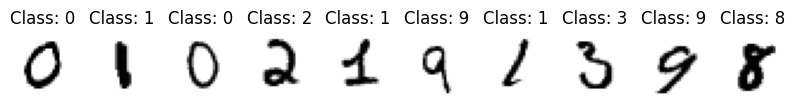

In [7]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

### Multi-layer perceptron (MLP) network

- "Flatten" the 2D image into a vector with nn.Flatten
- Create a fully-connected layer with 20 neurons
- Add a ReLU non-linear activation
- The output of the last layer needs to be a 10-dimensional vector to match the ground truth of ten classes (the ten digits).

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


#### Define a loss function and an optimizer

For a classification task we typically use the cross entropy loss.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

a helper function to calculate the number of correctly classified digits.

In [10]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones

The training function for a single epoch.

In [11]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

Train for 10 epochs:

In [12]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.429834, accuracy: 88.44%
Training epoch: 2
Average loss: 0.238427, accuracy: 93.24%
Training epoch: 3
Average loss: 0.200138, accuracy: 94.30%
Training epoch: 4
Average loss: 0.178499, accuracy: 94.87%
Training epoch: 5
Average loss: 0.163786, accuracy: 95.19%
Training epoch: 6
Average loss: 0.153337, accuracy: 95.54%
Training epoch: 7
Average loss: 0.144214, accuracy: 95.81%
Training epoch: 8
Average loss: 0.136840, accuracy: 95.95%
Training epoch: 9
Average loss: 0.130928, accuracy: 96.10%
Training epoch: 10
Average loss: 0.125242, accuracy: 96.33%
CPU times: user 43.3 s, sys: 5.68 s, total: 49 s
Wall time: 54.8 s


### Let's see the model accuracy for the test data

In [13]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [14]:
test(test_loader, model, criterion)

Testset accuracy: 95.8%, average loss: 0.148362


### Add one more hidden linear layer

Dropout: randomly set some neurons to zero in the forward pass in order to:
- prevent overfitting (we know the model is not using all its neurons)
- force the network to have a redundant representation (by killing part of the neurons, we know the network has to build redundacy for them)
The default probability for dropout is 0.5, half of the neurons.

In [26]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(50, 10)
        )        

    def forward(self, x):
        return self.layers(x)

In [27]:
ex1_model = TwoLayerMLP()
print(ex1_model)
ex1_model = ex1_model.to(device)


TwoLayerMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=50, out_features=10, bias=True)
  )
)


Same steps: a loss function, an optimizer and the training loop:

In [28]:
ex1_criterion = nn.CrossEntropyLoss()
ex1_optimizer = torch.optim.Adam(ex1_model.parameters())

In [29]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)

Epoch: 1 ...
Average loss: 0.470256, accuracy: 85.86%
Epoch: 2 ...
Average loss: 0.240145, accuracy: 92.88%
Epoch: 3 ...
Average loss: 0.199531, accuracy: 94.03%
Epoch: 4 ...
Average loss: 0.173506, accuracy: 94.78%
Epoch: 5 ...
Average loss: 0.159892, accuracy: 95.23%
Epoch: 6 ...
Average loss: 0.148368, accuracy: 95.55%
Epoch: 7 ...
Average loss: 0.140041, accuracy: 95.77%
Epoch: 8 ...
Average loss: 0.133137, accuracy: 95.90%
Epoch: 9 ...
Average loss: 0.127789, accuracy: 96.07%
Epoch: 10 ...
Average loss: 0.123514, accuracy: 96.25%
CPU times: user 57.6 s, sys: 6.57 s, total: 1min 4s
Wall time: 1min 11s


In [30]:
test(test_loader, ex1_model, ex1_criterion)


Testset accuracy: 97.1%, average loss: 0.094662


So, although the numbers look a bit worse on the training split, the result is acually better on the test split.